<a href="https://colab.research.google.com/github/isegura/seminarioUPM/blob/main/8_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT model 

In this notebook, we will train a system based on BERT to classify the sentiment of the tweets about Covid-19. 


[BERT - Kaggle](https://www.kaggle.com/nayansakhiya/text-classification-using-bert)

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
root='drive/My Drive/Colab Notebooks/seminarioUPM/'


Mounted at /content/drive


In [15]:
# reading the already cleaned data, paths are those obtained from google collab
train_data = pd.read_csv(root+'data/train.csv')
test_data = pd.read_csv(root+'data/test.csv')
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)
print(f'Training instances: {train_data.shape[0]}, and testing instances: {test_data.shape[0]}')


X_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,0]

y_train = train_data.iloc[:,1]
y_test = test_data.iloc[:,1]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)


train_text=X_train.to_numpy()
train_labels = y_train.to_numpy()
# making the test data into numpy formats
test_text = X_test.to_numpy()
test_labels = y_test.to_numpy()

Training instances: 41087, and testing instances: 3795


## Bert

Now we will aplly more specific tasks more related to the BERT algorithm, like the BERT tokenization or the BERT model itself. We will be importing these tools from the internet.

In [5]:
# import BERT tokenization

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [6]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 7.4MB/s 


In [7]:
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
#from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# keras
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Now we will import the BERT model from the hub.KerasLayer

In [8]:
# importing BERT Layer

m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

### Load the tokenizer functions

In [10]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

### Create the tokenization fuction

In [16]:
def bert_encode(texts, tokenizer, max_len=160):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### Now we perform the text encoding

In [25]:
train_input = bert_encode(train_text, tokenizer, max_len = 30)
test_input = bert_encode(test_text, tokenizer, max_len = 30)



## Defining model: BERT + softmax layer

In [23]:
def build_model(bert_layer, max_len=160):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    #lay = Dense(128, activation='relu')(clf_output)
    #lay = Dropout(0.2)(lay)
    #lay = Dense(64, activation='relu')(lay)
    #lay = Dropout(0.2)(lay)
    out = Dense(5, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(learning_rate=2e-6), loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.TruePositives()])
    
    return model

### Build the model

In [26]:
model = build_model(bert_layer, max_len = 30)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           



### Training

In [37]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=10,
    #batch_size=50,
    callbacks=[earlyStopping]
)

Epoch 1/10
1028/1028 [==============================] - 234s 228ms/step - loss: 0.2860 - accuracy: 0.6841 - precision_1: 0.6417 - recall_1: 0.4630 - true_positives_1: 62294.0312 - val_loss: 0.2670 - val_accuracy: 0.7049 - val_precision_1: 0.6527 - val_recall_1: 0.4909 - val_true_positives_1: 75992.3750
Epoch 2/10
1028/1028 [==============================] - 234s 227ms/step - loss: 0.2680 - accuracy: 0.7126 - precision_1: 0.6628 - recall_1: 0.5140 - true_positives_1: 90218.3359 - val_loss: 0.2573 - val_accuracy: 0.7213 - val_precision_1: 0.6712 - val_recall_1: 0.5334 - val_true_positives_1: 104481.1484
Epoch 3/10
1028/1028 [==============================] - 234s 227ms/step - loss: 0.2531 - accuracy: 0.7327 - precision_1: 0.6785 - recall_1: 0.5499 - true_positives_1: 119081.5547 - val_loss: 0.2552 - val_accuracy: 0.7296 - val_precision_1: 0.6858 - val_recall_1: 0.5651 - val_true_positives_1: 133906.3125
Epoch 4/10
1028/1028 [==============================] - 234s 228ms/step - loss: 0.240

### Learning curves

In [38]:
def plot_loss_acc(history):

    acc=history['accuracy']
    val_acc=history['val_accuracy']
    loss=history['loss']
    val_loss=history['val_loss']

    fig, axs = plt.subplots(2)
    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].set_title('Training and Validation Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train', 'Val'])
    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].set_title('Training and Validation Losses')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])
    fig.tight_layout()
    plt.show()

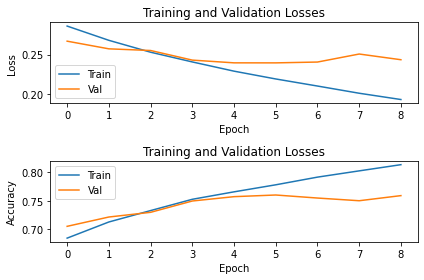

In [39]:
plot_loss_acc(train_history.history)

### Evaluation on test dataset

---



In [40]:
test_pred = model.predict(test_input)
test_pred = test_pred.round().astype(int)

In [41]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [42]:
# transforming the pred vectors to its label:
test_pred_cat = np.zeros(test_pred.shape[0],)
test_labels_cat = np.zeros(test_pred.shape[0],)
for i in range(0,test_pred.shape[0],1):
  test_pred_cat[i] = test_pred[i].argmax()
  test_labels_cat[i] = test_labels[i].argmax()

test_pred_cat = test_pred_cat.astype(int)
test_labels_cat = test_labels_cat.astype(int)

In [43]:
print(classification_report(test_labels_cat, test_pred_cat, target_names= labels.keys()))

                    precision    recall  f1-score   support

Extremely Negative       0.66      0.72      0.69       592
Extremely Positive       0.76      0.77      0.77       599
          Negative       0.67      0.67      0.67      1041
           Neutral       0.82      0.73      0.77       616
          Positive       0.66      0.67      0.66       947

          accuracy                           0.70      3795
         macro avg       0.71      0.71      0.71      3795
      weighted avg       0.70      0.70      0.70      3795



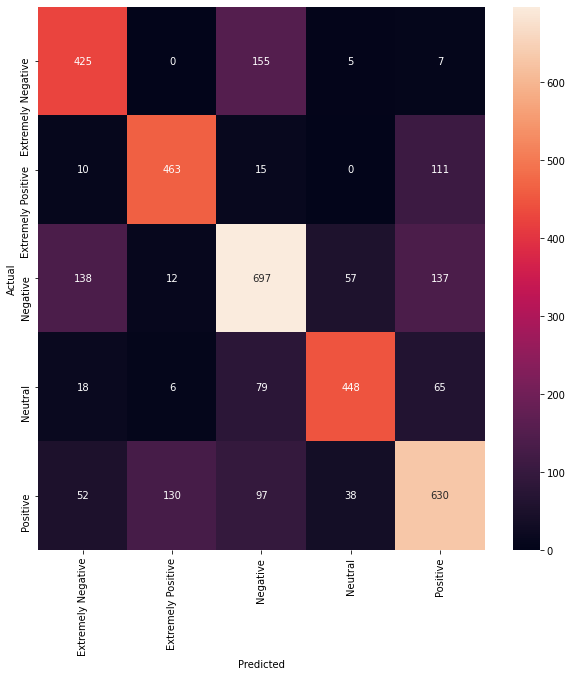

In [44]:
# confusion matrix

conf_mat = confusion_matrix(test_labels_cat, test_pred_cat)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()